In [1]:
from joblib import Parallel, delayed
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from utils import *
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [42]:
import seaborn as sns

In [ ]:
files = list(glob.glob('gecco/*'))
print(len(files))

1200


In [ ]:
generalization_dict = {}
for file in tqdm(files):
    df = pd.read_parquet(path=file)
    meta_model = df.metamodel.unique()[0]
    problem_out = df.removed_function.unique()[0]
    feature_group = df.feature_group.unique()[0]
    vd = df.groupby('alpha').mean(numeric_only=True).reset_index().sort_values('alpha')
    generalization_dict[(meta_model, problem_out, feature_group)] = (list(vd.alpha), list(vd.pairwise_error))

 99%|█████████▉| 1185/1200 [21:50<00:19,  1.30s/it]

In [92]:
errors = {}
feature_groups = list(np.unique([x[2] for x in list(generalization_dict.keys())]))
meta_models = list(np.unique([x[0] for x in list(generalization_dict.keys())]))


meta_model = 'RandomForestRegressor'
for feature_group in feature_groups:
    subset = [x for x in list(generalization_dict.keys()) if x[2]==feature_group and x[0]==meta_model]
    alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
    pw_errors = np.array([generalization_dict[x][1] for x in subset])
    errors[str(feature_group)] = (alphas, pw_errors)
    
meta_model = 'DummyRegressor'
feature_group = 'all'
subset = [x for x in list(generalization_dict.keys()) if x[2]==feature_group and x[0]==meta_model]
alphas = np.array([generalization_dict[x][0] for x in subset]).mean(axis=0)
pw_errors = np.array([generalization_dict[x][1] for x in subset])
errors['dummy'] = (alphas, pw_errors)

In [93]:
all_results=pd.concat([pd.DataFrame(v[1]).assign(features=k) if k!='dummy' else pd.DataFrame(v[1]).T.assign(features=k) for k,v in errors.items()])

In [94]:
all_results['is_norm']=all_results['features'].apply(lambda x: 'norm' in x and 'no_norm' not in x)

In [95]:
all_results['features']=all_results['features'].apply(lambda x: x.replace('_no_norm','').replace('norm_','').replace('_norm',''))

In [96]:
all_results=all_results.melt(['features','is_norm'],range(0,11))

In [97]:
all_results['alpha']=all_results['variable'].apply(lambda x: x/10)

<Figure size 640x480 with 0 Axes>

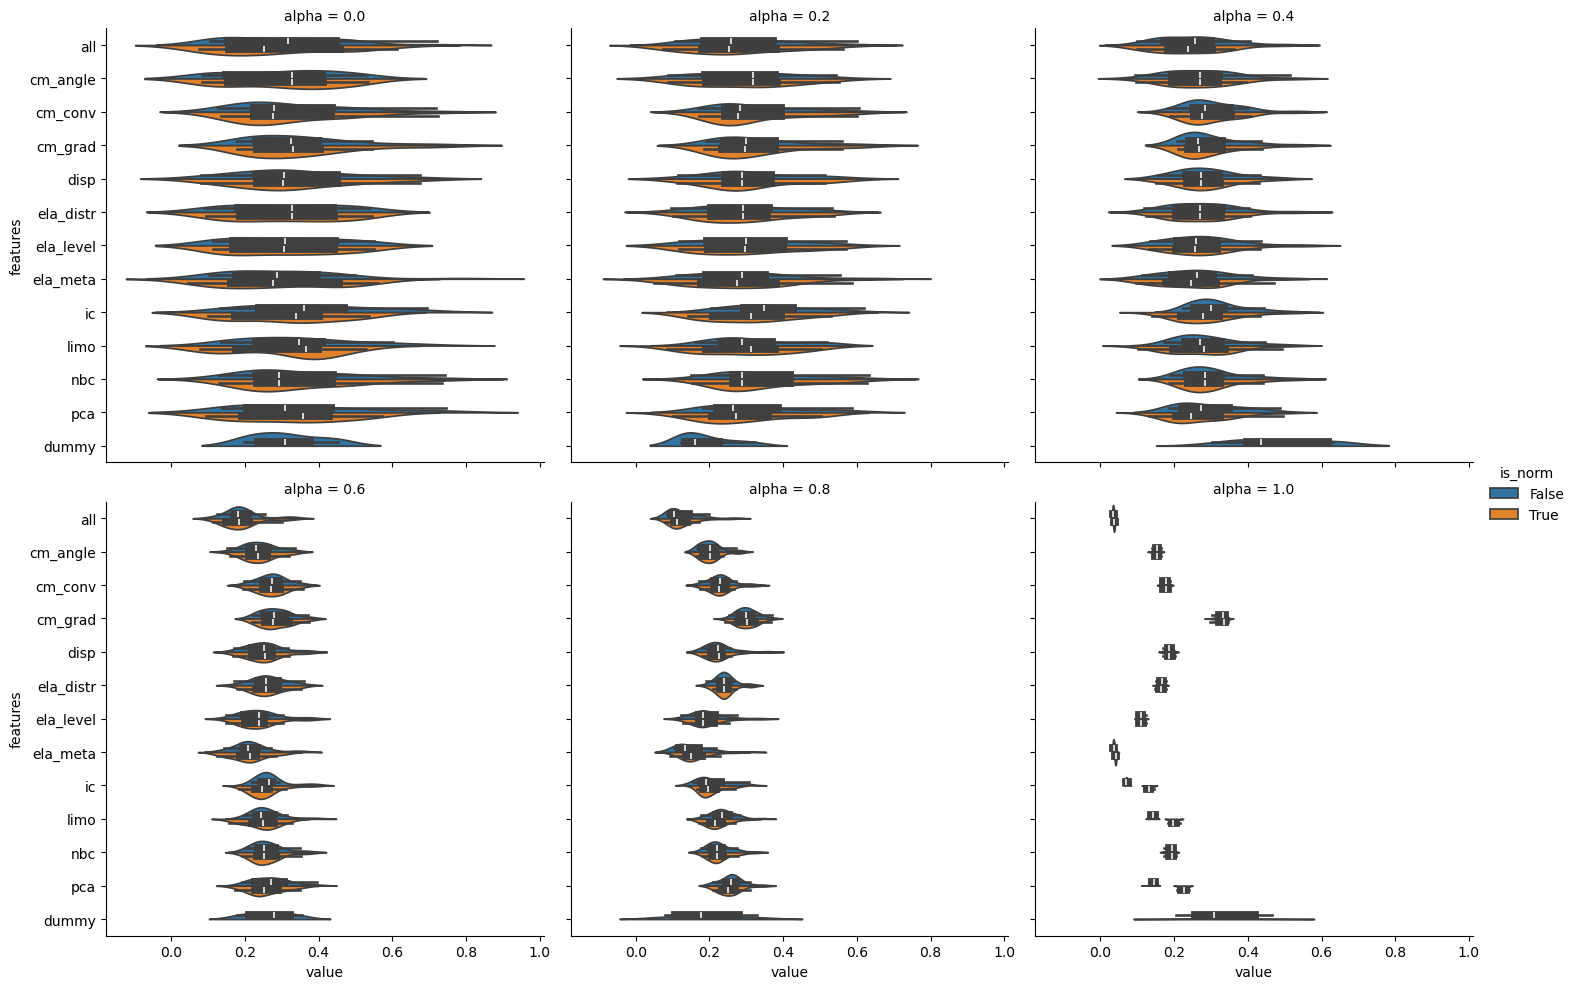

In [98]:
plt.figure()
ax=sns.catplot(all_results.query('alpha in [0,0.2,0.4,0.6,0.8,1]'), col='alpha',x='value',hue='is_norm',y='features',kind='violin',col_wrap=3,split=True)

plt.show()

<Figure size 640x480 with 0 Axes>

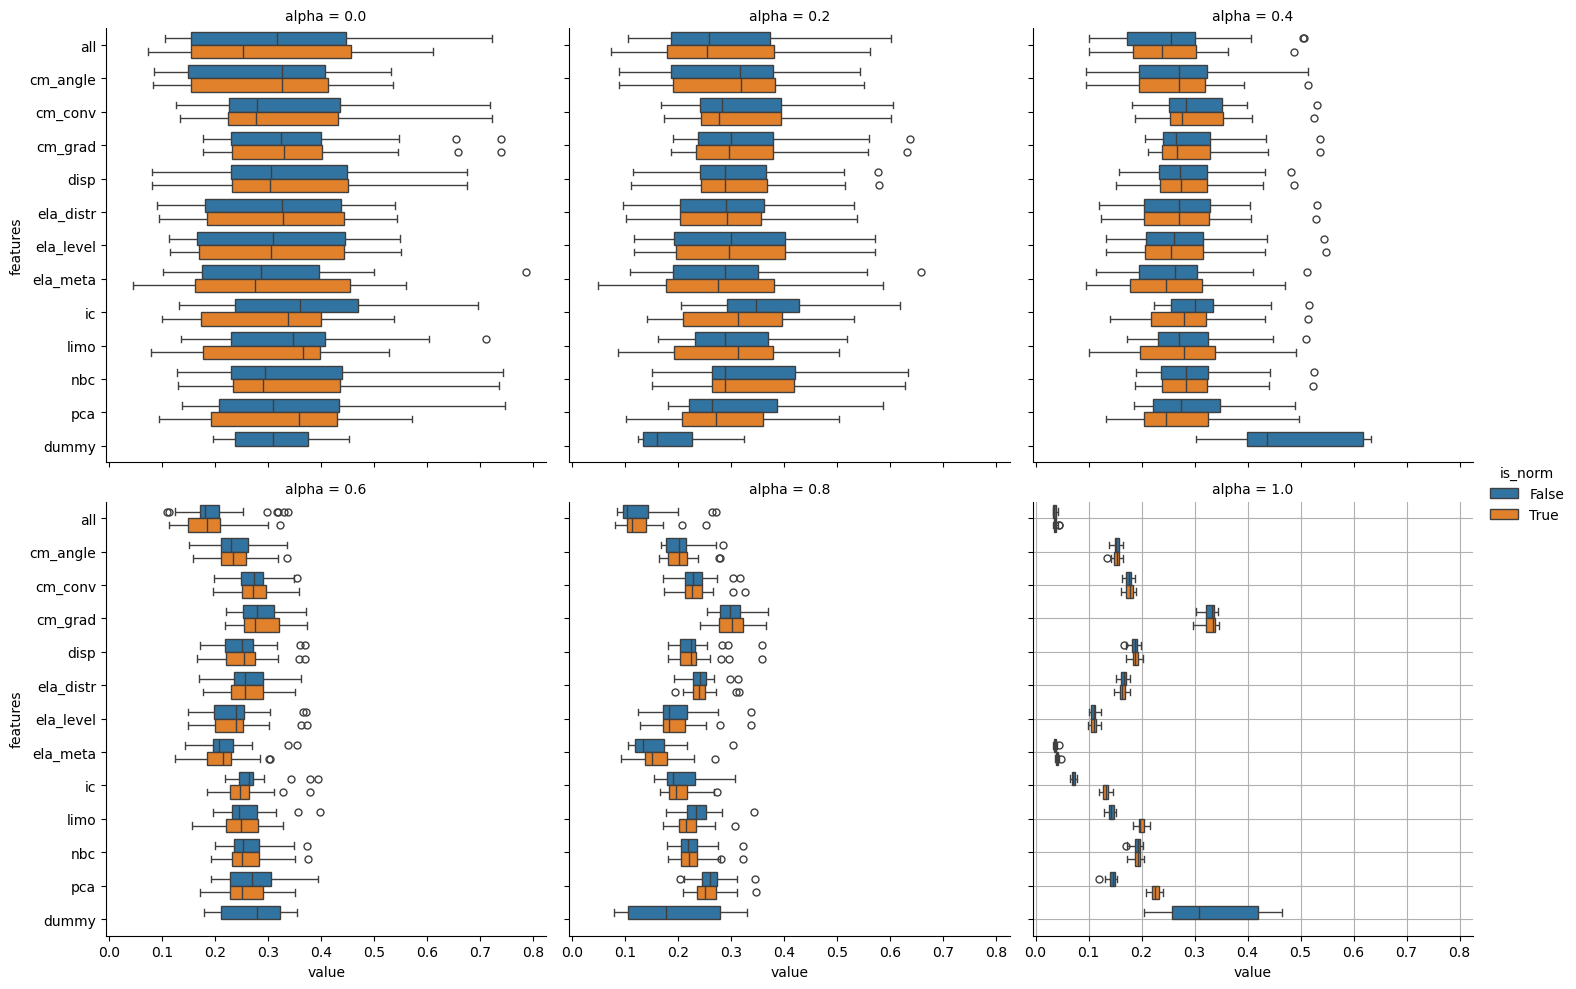

In [99]:
plt.figure()
axs=sns.catplot(all_results.query('alpha in [0,0.2,0.4,0.6,0.8,1]'), col='alpha',x='value',hue='is_norm',y='features',kind='box',col_wrap=3)
#for ax in axs:
#    ax.grid()
plt.grid()
plt.show()